# Objective
* 20190213:
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Instead of using last value method, we use prophet package to predict

In [4]:
%matplotlib inline

import math
import matplotlib
import multiprocessing
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import date, datetime, timedelta
from fbprophet import Prophet
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

#### Input params ##################
stk_path = "./data/TWII.csv"
H = 21                          # Forecast horizon
train_size = 252*3              # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                  # Use 1 year of data as validation set
changepoint_prior_scale_list = [0.05, 0.5, 1, 1.5, 2.5]     # for hyperparameter tuning
fourier_order_list = [None, 2, 4, 6, 8, 10]                 # for hyperparameter tuning
holidays_path = "./data/holidays.csv"                       # csv file containing holidays in the US
window_list = [None, 0, 1, 2]                               # for hyperparameter tuning

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

Importing plotly failed. Interactive plots will not work.


No. of days in train+validation set = 1008


In [5]:
print("We will start forecasting on day %d" % (train_val_size+1))

We will start forecasting on day 1009


# Common functions

In [55]:
def get_valid_nums(y_true, y_pred): 
    y_true_r = [] 
    y_pred_r = [] 
    idx = 0 
    y_true = y_true.to_numpy() 
    y_pred = y_pred.to_numpy()
    for i in range(0, len(y_true)):
        if not (math.isnan(y_true[i]) or math.isnan(y_pred[idx])): 
            y_true_r.append(y_true[i])
            y_pred_r.append(y_pred[idx])
        idx += 1 
    return y_true_r, y_pred_r    
            


def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def get_preds_prophet(df, H, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    Use Prophet to forecast for the next H timesteps, starting at df[len(df)]
    Inputs
        df: dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H : forecast horizon
        changepoint_prior_scale : to detect changepoints in time series analysis trajectories
        fourier_order           : determines how quickly seasonality can change
        holidays                : dataframe containing holidays you will like to model. 
                                  Must have 'holiday' and 'ds' columns
    Outputs
        A list of predictions
    """
    # Fit prophet model
    if holidays is not None:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=holidays)
    else:
        m = Prophet(changepoint_prior_scale=changepoint_prior_scale)
    if (fourier_order is not None) and (~np.isnan(fourier_order)): # add monthly seasonality
        m.add_seasonality(name='monthly', period=21, fourier_order=int(fourier_order))

    m.fit(df)
    
    # Make future dataframe
    future = m.make_future_dataframe(periods=2*H)
    
    # Eliminate weekend from future dataframe
    future['day'] = future['ds'].dt.weekday
    future = future[future['day']<=4]
    
    # Predict
    forecast = m.predict(future) # Note this prediction includes the original dates
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    return forecast['yhat'][len(df):len(df)+H]
    
def get_error_metrics(df, H, train_size, val_size, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale: to detect changepoints in time series analysis trajectories
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    assert len(df) == train_size + val_size
    
    # Predict using Prophet, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}
    
    rmse_mean, mape_mean, mae_mean = get_preds_prophet_parallelized(df, H, changepoint_prior_scale, fourier_order, holidays)

    return rmse_mean, mape_mean, mae_mean, _

def hyperparam_tune_cp(df, H, train_size, val_size, changepoint_prior_scale_list):
    """
    Hyperparameter tuning - changepoint
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale_list: list of changepoint_prior_scale values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for changepoint_prior_scale in tqdm_notebook(changepoint_prior_scale_list):
        print("changepoint_prior_scale = " + str(changepoint_prior_scale))
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, H, train_size, val_size, changepoint_prior_scale)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
    
    # Create results dataframe
    results = pd.DataFrame({'changepoint_prior_scale': changepoint_prior_scale_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    
    # Return hyperparam corresponding to lowest error metric
    return changepoint_prior_scale_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_fo(df, H, train_size, val_size, fourier_order_list):
    """
    Hyperparameter tuning - fourier order
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        fourier_order_list     : list of fourier_order values to try
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for fourier_order in tqdm_notebook(fourier_order_list):
        print("fourier_order = " + str(fourier_order))
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, H, train_size, val_size, 0.05, fourier_order)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Create results dataframe
    results = pd.DataFrame({'fourier_order': fourier_order_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Return hyperparam corresponding to lowest error metric
    return fourier_order_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_wd(df, H, train_size, val_size, window_list, holidays):
    """
    Hyperparameter tuning - upper and lower windows for holidays
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        window_list            : list of upper and lower window values to try
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for window in tqdm_notebook(window_list):
        print("window = " + str(window))
        
        if window is None:
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df=df, 
                                                                  H=H, 
                                                                  train_size=train_size, 
                                                                  val_size=val_size, 
                                                                  holidays=None)
        else:
            # Add lower_window and upper_window which extend the holiday out to 
            # [lower_window, upper_window] days around the date
            holidays['lower_window'] = -window
            holidays['upper_window'] = +window
        
            rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df=df, 
                                                                  H=H, 
                                                                  train_size=train_size, 
                                                                  val_size=val_size, 
                                                                  holidays=holidays)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Create results dataframe
    results = pd.DataFrame({'window': window_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Return hyperparam corresponding to lowest error metric
    return window_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_cp_fo_wd(df, H, train_size, val_size, changepoint_prior_scale_list, 
                             fourier_order_list, window_list, holidays):
    """
    Hyperparameter tuning - changepoint, fourier_order, holidays
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale_list: list of changepoint_prior_scale values to try
        fourier_order_list          : list of fourier_order values to try
        window_list                 : list of upper and lower window values to try
        holidays                    : dataframe containing holidays you will like to model. 
                                      Must have 'holiday' and 'ds' columns
    Outputs
        optimum hyperparameters
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    cp_list = []
    fo_list = []
    wd_list = []
    for changepoint_prior_scale in tqdm_notebook(changepoint_prior_scale_list):
        for fourier_order in tqdm_notebook(fourier_order_list):
            for window in tqdm_notebook(window_list):
                
                if window is None:
                    rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, 
                                                                          H, 
                                                                          train_size, 
                                                                          val_size, 
                                                                          changepoint_prior_scale, 
                                                                          fourier_order, 
                                                                          holidays=None)
                else:
                    # Add lower_window and upper_window which extend the holiday out to 
                    # [lower_window, upper_window] days around the date
                    holidays['lower_window'] = -window
                    holidays['upper_window'] = +window
        
                    rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(df, 
                                                                          H, 
                                                                          train_size, 
                                                                          val_size, 
                                                                          changepoint_prior_scale, 
                                                                          fourier_order, 
                                                                          holidays)
                rmse_mean_list.append(rmse_mean)
                mape_mean_list.append(mape_mean)
                mae_mean_list.append(mae_mean)
                cp_list.append(changepoint_prior_scale)
                fo_list.append(fourier_order)
                wd_list.append(window)
        
    # Return hyperparam corresponding to lowest error metric
    results = pd.DataFrame({'changepoint_prior_scale': cp_list, 
                            'fourier_order': fo_list,
                            'window': wd_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    temp = results[results['rmse'] == results['rmse'].min()]
    changepoint_prior_scale_opt = temp['changepoint_prior_scale'].values[0]
    fourier_order_opt = temp['fourier_order'].values[0]
    window_opt = temp['window'].values[0]
    
    return changepoint_prior_scale_opt, fourier_order_opt, window_opt, results



In [56]:
def processInput(i, df, H, changepoint_prior_scale, fourier_order, holidays):
    preds_list = get_preds_prophet(df[i-train_size:i], H, changepoint_prior_scale, fourier_order, holidays)
    
    # Compute error metrics
    print(df[i:i+H]['y'], preds_list)
    y_true_r, y_pred_r = get_valid_nums(df[i:i+H]['y'], preds_list)
    rmse = get_rmse(y_true_r, y_pred_r)
    mape = get_mape(y_true_r, y_pred_r)
    mae = get_mae(y_true_r, y_pred_r)
    
    return (rmse, mape, mae, df[i:i+H]['y'], preds_list)

def get_preds_prophet_parallelized(df, H, changepoint_prior_scale=0.05, fourier_order=None, holidays=None):
    """
    This is a parallelized implementation of get_preds_prophet.
    Given a dataframe consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                     : dataframe with headers 'ds' and 'y' (necessary for Prophet)
        H                      : forecast horizon
        train_size             : length of training set
        val_size               : length of validation set. Note len(df) = train_size + val_size
        changepoint_prior_scale: to detect changepoints in time series analysis trajectories
        fourier_order          : determines how quickly seasonality can change
        holidays               : dataframe containing holidays you will like to model. 
                                 Must have 'holiday' and 'ds' columns
    Outputs
        mean of rmse, mean of mape, mean of mae, dict of predictions
    """
    inputs = range(train_size, len(df)-H, int(H/2))

    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(delayed(processInput)(i, df, H, changepoint_prior_scale, fourier_order, holidays) for i in inputs)
    # results has format [(rmse1, mape1, mae1), (rmse2, mape2, mae2), ...]

    rmse = [errors[0] for errors in results]
    mape = [errors[1] for errors in results]
    mae = [errors[2] for errors in results]

    print("rmse, mape, mae")
    print(rmse, mape, mae)
    
    return np.mean(rmse), np.mean(mape), np.mean(mae)

# Load data

In [57]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

# Get size of dataframe
print("len(df) = " + str(len(df)))

df.head(10)

len(df) = 5782


,date,open,high,low,close,adj_close,volume
0,1997-07-02,9094.269531,9124.299805,8988.129883,8996.719727,8996.686523,0.0
1,1997-07-03,9061.599609,9061.599609,8997.509766,9027.629883,9027.596680,0.0
2,1997-07-04,9144.959961,9218.209961,9119.250000,9192.570313,9192.536133,0.0
3,1997-07-07,9365.190430,9370.410156,9304.820313,9322.839844,9322.805664,0.0
4,1997-07-08,9345.549805,9371.500000,9282.099609,9305.269531,9305.235352,0.0
5,1997-07-09,9391.280273,9415.580078,9343.299805,9362.679688,9362.645508,0.0
6,1997-07-10,9470.929688,9511.799805,9420.709961,9429.740234,9429.706055,0.0
7,1997-07-11,9498.070313,9526.740234,9333.790039,9394.629883,9394.595703,0.0
8,1997-07-14,9626.339844,9626.339844,9561.080078,9593.540039,9593.503906,0.0
9,1997-07-15,9714.780273,9714.780273,9451.450195,9555.980469,9555.945313,0.0


In [58]:
df['date'].min(), df['date'].max() 

(Timestamp('1997-07-02 00:00:00'), Timestamp('2020-06-19 00:00:00'))

Text(0, 0.5, 'USD')

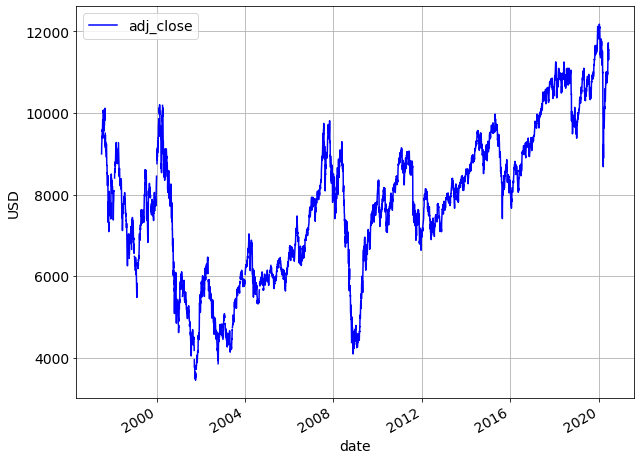

In [59]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [60]:
# Prepare dataframe for Prophet
df_prophet = df[['date', 'adj_close']].rename(columns={'date':'ds', 'adj_close':'y'})
df_prophet.head()

,ds,y
0,1997-07-02,8996.686523
1,1997-07-03,9027.596680
2,1997-07-04,9192.536133
3,1997-07-07,9322.805664
4,1997-07-08,9305.235352


# Predict for a specific H (forecast horizon) and a specific date

In [61]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2001-05-14 00:00:00, with forecast horizon H = 21


In [62]:
# Fit prophet model
m = Prophet()
m.fit(df_prophet[i-train_val_size:i])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [63]:
# Create dataframe with the dates we want to predict
future = m.make_future_dataframe(periods=2*H)

According to https://facebook.github.io/prophet/docs/non-daily_data.html, since we do not have weekend data, we should eliminate it from the future dataframe before doing predictions.

In [64]:
# Eliminate weekend from future dataframe
future['day'] = future['ds'].dt.weekday
future = future[future['day']<=4]

# Predict
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1033,2001-06-18,4653.276506,4177.762536,5074.841520
1034,2001-06-19,4629.714112,4157.082813,5131.494968
1035,2001-06-20,4626.258880,4172.504411,5098.504805
1036,2001-06-21,4620.207836,4151.242445,5086.782136
1037,2001-06-22,4615.739873,4113.772349,5104.895873


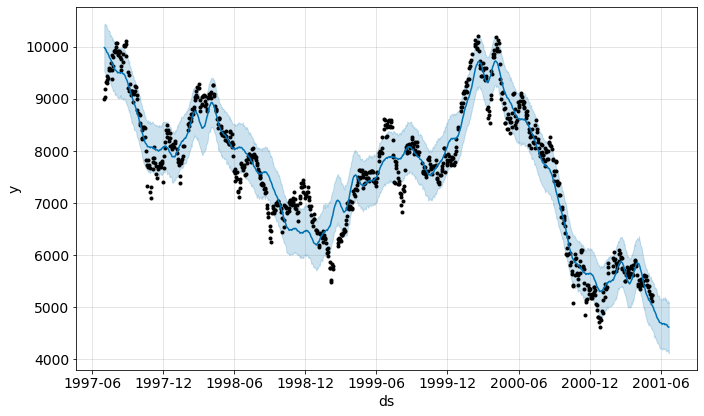

In [65]:
# Plot
m.plot(forecast);

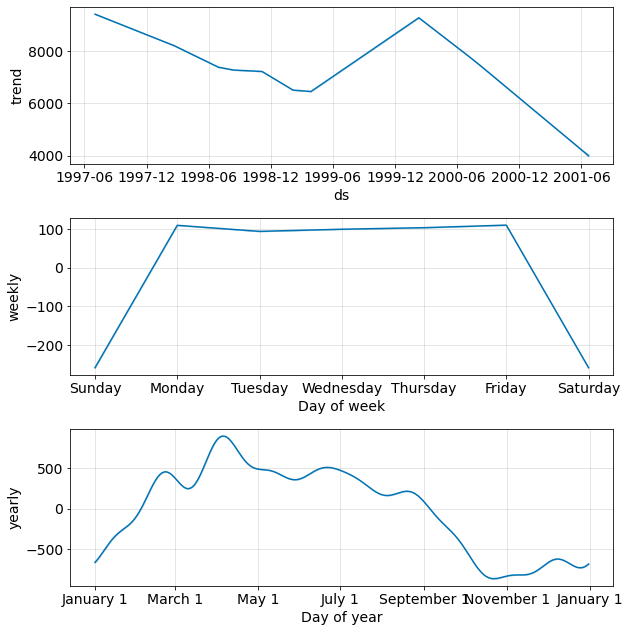

In [66]:
# Plot components
m.plot_components(forecast);

In [67]:
# Compute error metrics
preds_list = forecast['yhat'][train_val_size:train_val_size+H]
get_valid_nums(df_prophet[i:i+H]['y'], preds_list)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2001-05-14 00:00:00, the RMSE is 364.257606
For forecast horizon 21, predicting on day 1008, date 2001-05-14 00:00:00, the mean MAPE is 6.601796
For forecast horizon 21, predicting on day 1008, date 2001-05-14 00:00:00, the mean MAE is 339.139616


(730606.0, 730650.0)

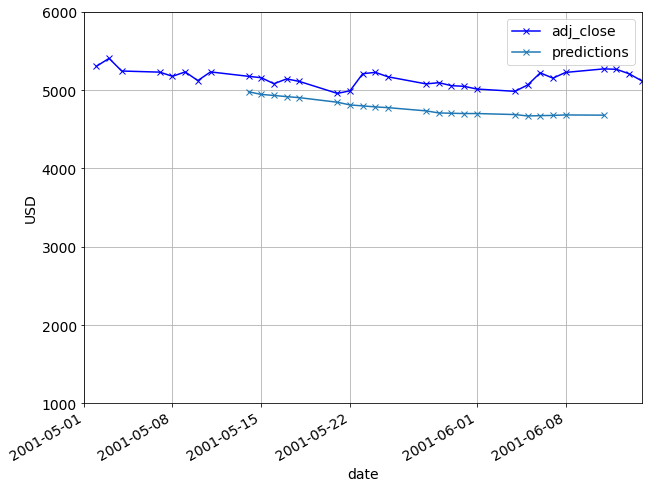

In [68]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([1000, 6000])
ax.set_xlim([date(2001, 5, 1), date(2001, 6, 14)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - changepoint

In [69]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2001-05-14 00:00:00, with forecast horizon H = 21


In [70]:
df_prophet[i-train_val_size:i]

,ds,y
0,1997-07-02,8996.686523
1,1997-07-03,9027.596680
2,1997-07-04,9192.536133
3,1997-07-07,9322.805664
4,1997-07-08,9305.235352
...,...,...
1003,2001-05-07,5229.910645
1004,2001-05-08,5176.690430
1005,2001-05-09,5232.620605
1006,2001-05-10,5122.150391


In [71]:
# Get optimum hyperparams
tic = time.time()
changepoint_opt, results = hyperparam_tune_cp(df_prophet[i-train_val_size:i], 
                                              H, 
                                              train_size, 
                                              val_size, 
                                              changepoint_prior_scale_list)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("changepoint_opt = " + str(changepoint_opt))

results

/Users/yianchen/workspace/Stocks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:116: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


changepoint_prior_scale = 0.05
rmse, mape, mae
[348.99567435990286, 567.997551744459, 707.6508579059927, 371.0398903939188, 135.5305861140976, 307.4076696661467, 263.0376071586621, 552.11535626895, 945.9700520093044, 1278.6527838337413, 972.6601604234135, 660.6163085094628, 616.0606217415726, 477.82444483284735, 366.4097732010051, 314.1041143071548, 790.2449872065486, 975.1500311048359, 636.4797933629458, 519.0072462185918, 585.2840041604396, 317.1404472443451, 324.93571851648295, 248.87273204365556] [3.2887810492370635, 5.584814650801144, 7.965008606173404, 3.986784209598239, 1.4529653433542025, 3.1427650735829147, 3.0161171083003544, 6.894821899169997, 13.967705960698689, 21.176926572892683, 16.55502013606689, 10.585760717291867, 10.646871085053974, 8.901752275984604, 6.523445973981796, 4.891882775270867, 11.947343339706945, 16.396475791013792, 10.674281365118302, 8.072906720951972, 9.763015855859043, 5.248971707394476, 5.084359299364546, 4.166943913329828] [286.58271875035354, 470.3

,changepoint_prior_scale,rmse,mape(%),mae
0,0.05,553.466184,8.330655,504.877992
1,0.50,476.790523,6.644763,420.826369
2,1.00,498.226735,6.865699,438.016653
3,1.50,540.411984,7.456763,477.137867
4,2.50,555.723205,7.656702,483.926492


In [72]:
# Get predictions using tuned hyperparams
preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, changepoint_prior_scale=changepoint_opt)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For forecast horizon 21, predicting on day 1008, date 2001-05-14 00:00:00, the RMSE is 173.140988
For forecast horizon 21, predicting on day 1008, date 2001-05-14 00:00:00, the mean MAPE is 2.728264
For forecast horizon 21, predicting on day 1008, date 2001-05-14 00:00:00, the mean MAE is 140.681162


(730606.0, 730640.0)

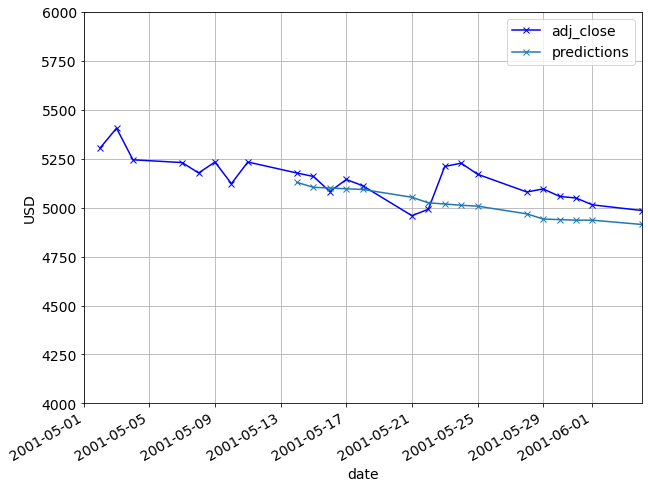

In [75]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([4000, 6000])
ax.set_xlim([date(2001, 5, 1), date(2001, 6, 4)])

With hyperparameter (changepoint_prior_scale) tuning, the predictions are more accurate

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - monthly seasonality

In [76]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

Predicting on day 1008, date 2001-05-14 00:00:00, with forecast horizon H = 21


In [77]:
# Get optimum hyperparams
tic = time.time()
fourier_order_opt, results = hyperparam_tune_fo(df_prophet[i-train_val_size:i], 
                                                H, 
                                                train_size, 
                                                val_size, 
                                                fourier_order_list)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("fourier_order_opt = " + str(fourier_order_opt))

results

/Users/yianchen/workspace/Stocks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:147: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


fourier_order = None
rmse, mape, mae
[348.99567435990286, 567.997551744459, 707.6508579059927, 371.0398903939188, 135.5305861140976, 307.4076696661467, 263.0376071586621, 552.11535626895, 945.9700520093044, 1278.6527838337413, 972.6601604234135, 660.6163085094628, 616.0606217415726, 477.82444483284735, 366.4097732010051, 314.1041143071548, 790.2449872065486, 975.1500311048359, 636.4797933629458, 519.0072462185918, 585.2840041604396, 317.1404472443451, 324.93571851648295, 248.87273204365556] [3.2887810492370635, 5.584814650801144, 7.965008606173404, 3.986784209598239, 1.4529653433542025, 3.1427650735829147, 3.0161171083003544, 6.894821899169997, 13.967705960698689, 21.176926572892683, 16.55502013606689, 10.585760717291867, 10.646871085053974, 8.901752275984604, 6.523445973981796, 4.891882775270867, 11.947343339706945, 16.396475791013792, 10.674281365118302, 8.072906720951972, 9.763015855859043, 5.248971707394476, 5.084359299364546, 4.166943913329828] [286.58271875035354, 470.36715205039

,fourier_order,rmse,mape(%),mae
0,NaN,553.466184,8.330655,504.877992
1,2.0,557.332957,8.382932,508.308148
2,4.0,552.127951,8.292137,503.527561
3,6.0,560.952311,8.426080,512.075820
4,8.0,558.142082,8.412341,509.811853
5,10.0,566.522304,8.509534,516.731345


In [ ]:
# Get predictions using tuned hyperparams
preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, fourier_order=fourier_order_opt)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

In [ ]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - holidays

In [ ]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

In [ ]:
# Load holidays file
hols = pd.read_csv(holidays_path, header=None, sep="\t", names=['ds', 'holiday'])

# Convert Date column to datetime
hols.loc[:, 'ds'] = pd.to_datetime(hols['ds'],format='%Y-%m-%d')

# Add lower_window and upper_window which extend the holiday out to [lower_window, upper_window] days around the date
hols['lower_window'] = 0
hols['upper_window'] = 0

hols.head()

In [ ]:
# Get optimum hyperparams
tic = time.time()
window_opt, results = hyperparam_tune_wd(df_prophet[i-train_val_size:i], 
                                         H, 
                                         train_size, 
                                         val_size, 
                                         window_list,
                                         hols)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("window_opt = " + str(window_opt))

results

In [ ]:
# Get predictions using tuned hyperparams
if window_opt is None:
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, holidays=None)
else:
    hols['lower_window'] = -window_opt
    hols['upper_window'] = +window_opt
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], H, holidays=hols)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

In [ ]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon) and a specific date, with hyperparameter tuning - changepoint, monthly seasonality, holidays

In [ ]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

In [ ]:
# Get optimum hyperparams
tic = time.time()
changepoint_prior_scale_opt, fourier_order_opt, window_opt, results = \
    hyperparam_tune_cp_fo_wd(df_prophet[i-train_val_size:i], 
                             H, 
                             train_size, 
                             val_size, 
                             changepoint_prior_scale_list,
                             fourier_order_list,
                             window_list,
                             hols)
toc = time.time()
print("Time taken = " + str((toc-tic)/60.0) + " mins")

print("changepoint_prior_scale_opt = " + str(changepoint_prior_scale_opt))
print("fourier_order_opt = " + str(fourier_order_opt))
print("window_opt = " + str(window_opt))
results

In [ ]:
# Print the tail of the results df
results.tail()

In [ ]:
# Get predictions using tuned hyperparams
if (window_opt is None) or (np.isnan(window_opt)):
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                   H, 
                                   changepoint_prior_scale_opt, 
                                   fourier_order_opt, 
                                   holidays=None)
else:
    hols['lower_window'] = -window_opt
    hols['upper_window'] = +window_opt
    preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                   H, 
                                   changepoint_prior_scale_opt, 
                                   fourier_order_opt, 
                                   holidays=hols)
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df_prophet[i:i+H]['y'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df_prophet[i:i+H]['y'], preds_list)))

In [ ]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 120])
ax.set_xlim([date(2016, 11, 1), date(2017, 2, 28)])

# Predict for a specific H (forecast horizon), and various dates, using model trained in previous step

In [ ]:
changepoint_prior_scale_opt = 2.5
fourier_order_opt = 10
window_opt = None

In [ ]:
# Predict using Prophet, and compute error metrics also
rmse = [] # root mean square error
mape = [] # mean absolute percentage error
mae = []  # mean absolute error
preds_dict = {}
H = 21 # We will test with this value of H and observe the results
i_list = range(train_val_size, train_val_size+84*5+42+1, 42)
for i in i_list:
# for i in tqdm_notebook(range(train_val_size, len(df)-H, int(H/2))): # Do a forecast on day i
    print("Predicting on day %d, date %s" % (i, df_prophet['ds'][i]))
    
    # Get predictions using tuned hyperparams
    if (window_opt is None) or (np.isnan(window_opt)):
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=None)
    else:
        hols['lower_window'] = -window_opt
        hols['upper_window'] = +window_opt
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=hols)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    rmse.append(get_rmse(df_prophet[i:i+H]['y'], preds_list))
    mape.append(get_mape(df_prophet[i:i+H]['y'], preds_list))
    mae.append(get_mae(df_prophet[i:i+H]['y'], preds_list))

print("Altogether we made %d forecasts, each of length %d days" % (len(rmse), H))

In [ ]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

In [ ]:
results_final_no_tune = pd.DataFrame({'day': i_list,
                                      'changepoint_opt': [changepoint_prior_scale_opt]*len(i_list),
                                      'fourier_order_opt': [fourier_order_opt]*len(i_list),
                                      'window_opt': [window_opt]*len(i_list),
                                      'rmse': rmse,
                                      'mape': mape,
                                      'mae': mae})
results_final_no_tune

In [ ]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([105, 150])
ax.set_xlim([date(2017, 1, 1), date(2018, 12, 31)])

# Predict for a specific H (forecast horizon), and various dates, tuning model for every prediction

In [ ]:
i_list = [train_val_size+294, train_val_size+378, train_val_size+462]
for i in i_list:
    print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df_prophet.iloc[i]['ds'], H))

    # Predict using Prophet, and compute error metrics also
    rmse = [] # root mean square error
    mape = [] # mean absolute percentage error
    mae = []  # mean absolute error
    preds_dict = {}

    tic = time.time()
    
    changepoint_prior_scale_opt, fourier_order_opt, window_opt, results = \
        hyperparam_tune_cp_fo_wd(df_prophet[i-train_val_size:i], 
                                 H, 
                                 train_size, 
                                 val_size, 
                                 changepoint_prior_scale_list,
                                 fourier_order_list,
                                 window_list,
                                 hols)
    
    # Get predictions using tuned hyperparams
    if (window_opt is None) or (np.isnan(window_opt)):
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=None)
    else:
        hols['lower_window'] = -window_opt
        hols['upper_window'] = +window_opt
        preds_list = get_preds_prophet(df_prophet[i-train_val_size:i], 
                                       H, 
                                       changepoint_prior_scale_opt, 
                                       fourier_order_opt, 
                                       holidays=hols)
    
    # Compute error metrics
    rmse = get_rmse(df_prophet[i:i+H]['y'], preds_list)
    mape = get_mape(df_prophet[i:i+H]['y'], preds_list)
    mae = get_mae(df_prophet[i:i+H]['y'], preds_list)

    # Put results into pickle
    pickle.dump(preds_list, open("./data/preds_list_" + str(i) + ".pickle", "wb"))
    pickle.dump(rmse, open("./data/rmse_" + str(i) + ".pickle", "wb"))
    pickle.dump(mape, open("./data/mape_" + str(i) + ".pickle", "wb"))
    pickle.dump(mae, open("./data/mae_" + str(i) + ".pickle", "wb"))
    pickle.dump(changepoint_prior_scale_opt, open("./data/changepoint_prior_scale_opt_" + str(i) + ".pickle", "wb"))
    pickle.dump(fourier_order_opt, open("./data/fourier_order_opt_" + str(i) + ".pickle", "wb"))
    pickle.dump(window_opt, open("./data/window_opt_" + str(i) + ".pickle", "wb"))
    pickle.dump(results, open("./data/results_" + str(i) + ".pickle", "wb"))
    
    toc = time.time()
    print("Time taken = " + str((toc-tic)/60.0))

In [ ]:
# Load pickle file
i_list = range(train_val_size, train_val_size+84*5+42+1, 42)
# i_list = [train_val_size, train_val_size+42, train_val_size+84, train_val_size+126, train_val_size+84*2, 
#           train_val_size+210, train_val_size+84*3, train_val_size+84*4, train_val_size+84*5]
preds_dict = {}
rmse, mape, mae, changepoint_prior_scale_opt, fourier_order_opt, window_opt = [], [], [], [], [], []

for i in i_list:
    preds_dict[i] = pickle.load(open( "./data/preds_list_" + str(i) + ".pickle", "rb"))
    rmse.append(pickle.load(open( "./data/rmse_" + str(i) + ".pickle", "rb")))
    mape.append(pickle.load(open( "./data/mape_" + str(i) + ".pickle", "rb")))
    mae.append(pickle.load(open( "./data/mae_" + str(i) + ".pickle", "rb")))
    changepoint_prior_scale_opt.append(pickle.load(open( "./data/changepoint_prior_scale_opt_" + str(i) + ".pickle", "rb")))
    fourier_order_opt.append(pickle.load(open( "./data/fourier_order_opt_" + str(i) + ".pickle", "rb")))
    window_opt.append(pickle.load(open( "./data/window_opt_" + str(i) + ".pickle", "rb")))

In [ ]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

In [ ]:
results_final = pd.DataFrame({'day': i_list,
                              'changepoint_opt': changepoint_prior_scale_opt,
                              'fourier_order_opt': fourier_order_opt,
                              'window_opt': window_opt,
                              'rmse': rmse,
                              'mape': mape,
                              'mae': mae})
results_final

In [ ]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_ylim([105, 150])
ax.set_xlim([date(2017, 1, 1), date(2018, 12, 31)])

# Findings


In [ ]:
# Consolidate results from hyperparameter tuning
pd.set_option('display.max_colwidth', -1)  # or 199
results = pd.DataFrame({'Method': ['Last Value', 
                                   'Prophet - no hyperparameter tuning', 
                                   'Prophet tuning changepoint', 
                                   'Prophet tuning fourier order', 
                                   'Prophet tuning window size', 
                                   'Prophet tuning changepoint, fourier order, and window size'],
                        'RMSE'    : [2.56, 3.40, 0.64, 3.52, 3.40, 0.55],
                        'MAPE(%)' : [1.65, 2.87, 0.52, 2.98, 2.87, 0.41],
                        'MAE'     : [2.19, 3.25, 0.58, 3.37, 3.25, 0.47]                       
                       })
results